In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lr.text_processing.util import pre_process_nli_df
from lr.training.util import get_ternary_label
from lr.text_processing.transformations.structural import entailment_internalization
from lr.text_processing.transformations.synonyms import toy_transformation
from lr.stats.h_testing import DGP, get_matched_results, get_paired_t_statistic
from lr.stats.h_testing import get_boot_sample_under_H0,get_boot_p_value
from lr.stats.h_testing import  LIMts_test
from lr.training.language_representation import Tfidf
from lr.models.logistic_regression import LRWrapper
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

### Loading data

In [2]:
train_path = "data/toy/train.csv"
dev_path = "data/toy/dev.csv"
train = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)
pre_process_nli_df(train)
pre_process_nli_df(dev)

### Training a model using one version of the modified data

In [3]:
max_features = 500
rho = 0.001
label_translation = get_ternary_label
transformation = entailment_internalization 

dgp = DGP(data=train, transformation=transformation, rho=rho)
train_t = dgp.get_sample()

hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}
lr = LRWrapper(hyperparams)
lr.fit(train_t)

### Get t statistic for the observable results and matched results

In [4]:
dev_t = transformation(dev)

results = get_matched_results(dev, dev_t, lr, lr.label_translation)
t_obs = get_paired_t_statistic(results)

print(t_obs)

-1.2964074471043285


### Get $S$ bootstrap replications under H0

In [5]:
S = 1000
t_boots = []
for _ in range(S):
    boot_sample = get_boot_sample_under_H0(results)
    t = get_paired_t_statistic(boot_sample)
    t_boots.append(t)

t_boots = pd.Series(t_boots)

### Calculating the associated p-value

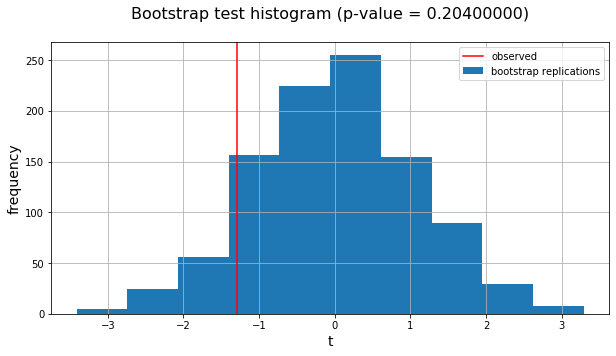

In [6]:
p_value = get_boot_p_value(t_boots, t_obs)

fig, ax = plt.subplots(figsize=(10,5))
t_boots.hist(ax=ax, label="bootstrap replications");
plt.axvline(x=t_obs, color='r', linestyle='-', label="observed");
ax.set_xlabel("t", fontsize=14);
ax.set_ylabel("frequency", fontsize=14);
ax.set_title("Bootstrap test histogram (p-value = {:.8f})".format(p_value) +"\n", fontsize=16)
plt.legend(loc="best");

### Performing multiple tests

**test1: entailment internalization**

In [7]:
M,E,S = 5,1,1000


tests1 = LIMts_test(train=train,
                   dev=dev,
                   transformation=entailment_internalization,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests1

,m,e,observable_t_stats,p_value,time,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,-8.056095,0.0,2.764807,-1.183660,-0.137367,-0.701000,0.000000,0.447437,...,0.294948,0.000000,0.000000,-0.288735,-0.566139,-0.420269,1.023727,-0.950825,-1.210455,-0.160138
1,2,1,-8.273837,0.0,2.577779,1.393466,-0.534905,-0.301580,-0.277403,1.854020,...,0.137367,-1.023727,-0.493497,-1.183660,1.766542,-0.130194,0.715199,-1.519665,1.183660,0.000000
2,3,1,-7.838234,0.0,2.622548,1.046351,-1.091902,-0.160138,-1.412558,-0.782062,...,0.633089,1.448695,-0.324528,-0.801927,0.886388,-1.096497,-0.343098,-0.235735,0.701000,-1.581221
3,4,1,-8.164966,0.0,2.648875,1.339299,0.000000,-0.420269,-0.555127,1.549526,...,1.091902,-0.640841,0.134846,-2.123977,-0.437805,0.140035,0.000000,0.132459,-0.140035,0.142864
4,5,1,-8.164966,0.0,2.634927,-0.258242,0.000000,0.982559,0.534905,-1.464780,...,-0.390716,1.135009,-1.393466,0.000000,1.240996,-1.462980,0.000000,-0.288735,-0.145873,0.833494


### Diferent bootstrap distributions for each experiment

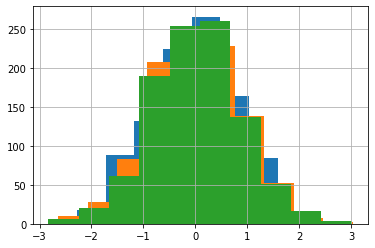

In [8]:
tests1.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests1.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

**test2: toy transformation**

In [9]:
tests2 = LIMts_test(train=train,
                   dev=dev,
                   transformation=toy_transformation,
                   rho=0.78,
                   Model=LRWrapper,
                   hyperparams=hyperparams,
                   M=M,
                   E=E,
                   S=S)

tests2

,m,e,observable_t_stats,p_value,time,boot_t_1,boot_t_2,boot_t_3,boot_t_4,boot_t_5,...,boot_t_991,boot_t_992,boot_t_993,boot_t_994,boot_t_995,boot_t_996,boot_t_997,boot_t_998,boot_t_999,boot_t_1000
0,1,1,0.378100,0.730,2.652996,-1.643990,-0.817861,2.571297,0.577832,0.000000,...,-0.817861,-1.002509,-0.333426,1.270001,-1.643990,0.447437,-1.137556,-0.817861,1.421338,-1.347719
1,2,1,0.000000,0.926,3.079986,-0.626156,0.471667,0.258242,0.633089,0.577832,...,0.000000,0.944911,-2.162952,0.242571,1.745189,0.534905,0.258242,0.000000,0.301580,0.242571
2,3,1,0.906390,0.342,3.171580,0.000000,-0.577832,-1.270001,-1.643990,-1.137556,...,0.833494,0.906390,0.577832,1.002509,0.301580,-0.378100,0.277403,-0.301580,-1.002509,-1.002509
3,4,1,-0.633089,0.560,2.928428,0.500313,-0.378100,-0.471667,0.534905,-2.721655,...,-0.301580,-1.822336,-1.296407,0.447437,0.000000,1.270001,0.000000,0.000000,-1.137556,-0.378100
4,5,1,-0.378100,0.768,2.708773,-1.745189,1.137556,0.633089,1.643990,2.487080,...,1.137556,0.707992,-1.002509,-0.707992,0.000000,1.347719,-0.378100,1.137556,-0.447437,1.137556


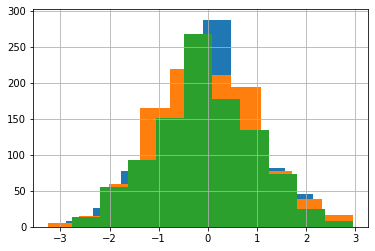

In [10]:
tests2.iloc[0][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[2][["boot_t_{}".format(i+1) for i in range(S)]].hist();
tests2.iloc[3][["boot_t_{}".format(i+1) for i in range(S)]].hist();

In [11]:
assert np.all(tests1.p_value < (0.05/M*E))
assert not np.all(tests2.p_value < (0.05/M*E))